#!pip install mediapipe-model-maker


import os
import pathlib
import tensorflow as tf
assert tf.__version__.startswith('2')

from mediapipe_model_maker import gesture_recognizer

import matplotlib.pyplot as plt

path=str(pathlib.Path().resolve())+"/"

from genericpath import isfile
from os import listdir, mkdir
import shutil

if not os.path.exists(path+"Piedra_Papel_Tijera_Formated"):
    gestos=([],[],[],[])
    directories = [f for f in listdir(path+"Piedra_Papel_Tijeras")]
    for i in directories:
        for index,(dirpath, dirnames, filenames) in enumerate(os.walk(path+"Piedra_Papel_Tijeras/"+i+"/")):
            if len(dirnames)==0:
                for filename in filenames:
                    gestos[index-1].append(dirpath+"/"+filename)
    mkdir(path+"Piedra_Papel_Tijera_Formated")
    mkdir(path+"Piedra_Papel_Tijera_Formated/None")
    mkdir(path+"Piedra_Papel_Tijera_Formated/Piedra")
    mkdir(path+"Piedra_Papel_Tijera_Formated/Papel")
    mkdir(path+"Piedra_Papel_Tijera_Formated/Tijeras")

# Comprueba si el directorio existe
    if not os.path.exists(path):
    # Si no existe, créalo
        os.makedirs(path)
    for index,i in enumerate(gestos):
        for j in i:
            split=i[index].split("/")
            split.remove(split[-3])
            shutil.copy(j,path+"Piedra_Papel_Tijera_Formated/"+split[-2].title())


data = gesture_recognizer.Dataset.from_folder(
    dirname=os.path.join(path,"Piedra_Papel_Tijera_Formated"),
    hparams=gesture_recognizer.HandDataPreprocessingParams()
)
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

hparams = gesture_recognizer.HParams(export_dir="exported_model")
options = gesture_recognizer.GestureRecognizerOptions(hparams=hparams)
model = gesture_recognizer.GestureRecognizer.create(
    train_data=train,
    validation_data=validation,
    options=options
)

from google.colab import files
model.export_model()
files.download('exported_model/gesture_recognizer.task')

hparams = gesture_recognizer.HParams(learning_rate=0.003, export_dir="exported_model_2")
model_options = gesture_recognizer.ModelOptions(dropout_rate=0.2)
options = gesture_recognizer.GestureRecognizerOptions(model_options=model_options, hparams=hparams)
model_2 = gesture_recognizer.GestureRecognizer.create(
    train_data=train_data,
    validation_data=validation_data,
    options=options
)

loss, accuracy = model.evaluate(test_data)
print(f"Test loss:{loss}, Test accuracy:{accuracy}")
loss, accuracy = model_2.evaluate(test_data)
print(f"Test loss:{loss}, Test accuracy:{accuracy}")

from google.colab import files
model_2.export_model()
files.download('exported_model/gesture_recognizer.task')

# pip install --upgrade protobuf 
# No instalar el model maker si eres de Windows

In [324]:
import pathlib


path=str(pathlib.Path().resolve())+"/"

In [325]:
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Cargamos las opciones del modelo
model_path = path+'gesture_recognizer_FINAL.task'
base_options = python.BaseOptions(model_asset_path=model_path)

In [327]:
# region Código de MediaPipe

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)
  

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.

  return annotated_image

# endregion

In [328]:
import math
import cv2 as cv

def text(imagen,hand_landmarker_result,w,h):
    """ Escribe el texto de la solución x mano

    Args:
        imagen (CV.IMAGE): Imagen
        hand_landmarker_result (Result): Resultado de la detección
        w (float): width
        h (float): height

    Returns:
        CV.IMAGE: Imagen
    """
    for index,landmark in enumerate(hand_landmarker_result.hand_landmarks):
        x_max = 0
        y_max = 0
        x_min = w
        y_min = h
        points=[]
        for point in landmark:
            x, y = int(point.x * w), int(point.y * h)
            points.append((point.x,point.y,point.z))
            if x > x_max:
                x_max = x
            if x < x_min:
                x_min = x
            if y > y_max:
                y_max = y
            if y < y_min:
                y_min = y
        top_gesture = detection_result.gestures[index][0]
        hand_landmarks = detection_result.hand_landmarks
        results = (top_gesture, hand_landmarks)
        title = results[0].category_name
        a=(x_min,y_min)
        imagen=cv.putText(np.copy(imagen), title, a,  cv.FONT_HERSHEY_SIMPLEX, 2, (255,0,0),2)
    return imagen


In [329]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

video = cv.VideoCapture(0)
while(True):
    ret, frame = video.read()
    if ret == True:
        frame = cv.flip(frame, 1)
        h, w, c = frame.shape
        cv.imshow("Salida", frame)
        image_bgr = cv.cvtColor(frame, cv.COLOR_RGB2BGR)

        options = vision.GestureRecognizerOptions(base_options=base_options,num_hands=2)
        detector = vision.GestureRecognizer.create_from_options(options)

        imagen_f=mp.Image(image_format=mp.ImageFormat.SRGB, data=image_bgr)
        detection_result = detector.recognize(imagen_f)
        
        # Si tiene gestos los detecta si no lo transforma en numpy image
        if len(detection_result.gestures)>0:
            imagen_f=text(imagen_f.numpy_view(),detection_result,h,w)
            imagen_f=draw_landmarks_on_image(imagen_f, detection_result)
        else:
            imagen_f = imagen_f.numpy_view()
            
        cv.imshow("Result", cv.cvtColor(imagen_f,cv.COLOR_BGR2RGB))
    if ret == False:
        video.set(cv.CAP_PROP_POS_FRAMES, 0)
    if cv.waitKey(10) & 0xFF == 27: break

video.release()
cv.destroyAllWindows()

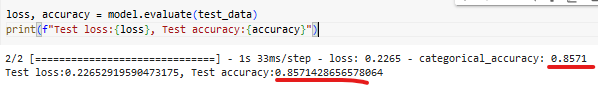